In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import hvplot.pandas
import plotly.express as px
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import  risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import plotting

import warnings
warnings.filterwarnings("ignore")


In [2]:
#formatting floats to 2 decimals to avoid use of scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [3]:
#Defining symbols in our portfolio.
tickers = ["TSLA", "BIDU", "NVDA", "AAL", "AMD", "WMT", "DIS", "DHR", "PANW","AAPL","MCL.CN","FI"] 

In [4]:
portfolio_creation_date = "2023-11-10"
portfolio_rebalance_date = "2023-11-10"

In [5]:
#Downloading 10 years of data from yahoo finance.
stock_data = yf.download(tickers, period="10y")

[*********************100%%**********************]  12 of 12 completed


In [6]:
#putting stock data into a df called prices
prices = pd.DataFrame(stock_data["Adj Close"].dropna(how="all"))
prices

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-11,21.94,16.25,3.34,151.60,47.24,62.13,26.34,0.02,3.68,13.96,9.65,63.73
2013-11-12,22.17,16.28,3.44,150.43,46.94,61.61,26.41,0.02,3.69,13.76,9.19,63.48
2013-11-13,21.98,16.30,3.54,152.98,46.85,62.70,26.80,0.02,3.79,13.82,9.25,63.64
2013-11-14,22.31,16.54,3.52,158.99,47.29,63.65,26.80,0.02,3.81,14.07,9.17,63.78
2013-11-15,22.52,16.44,3.50,162.33,47.32,63.64,27.15,0.02,3.79,15.24,9.03,63.90
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,11.66,178.99,111.75,108.40,195.52,84.02,119.64,0.08,457.51,237.00,219.27,164.88
2023-11-07,11.75,181.58,113.45,108.01,198.25,84.59,119.21,0.08,459.55,242.08,222.18,165.65
2023-11-08,12.01,182.65,113.59,107.42,196.82,84.50,120.13,0.08,465.74,241.08,222.11,164.30


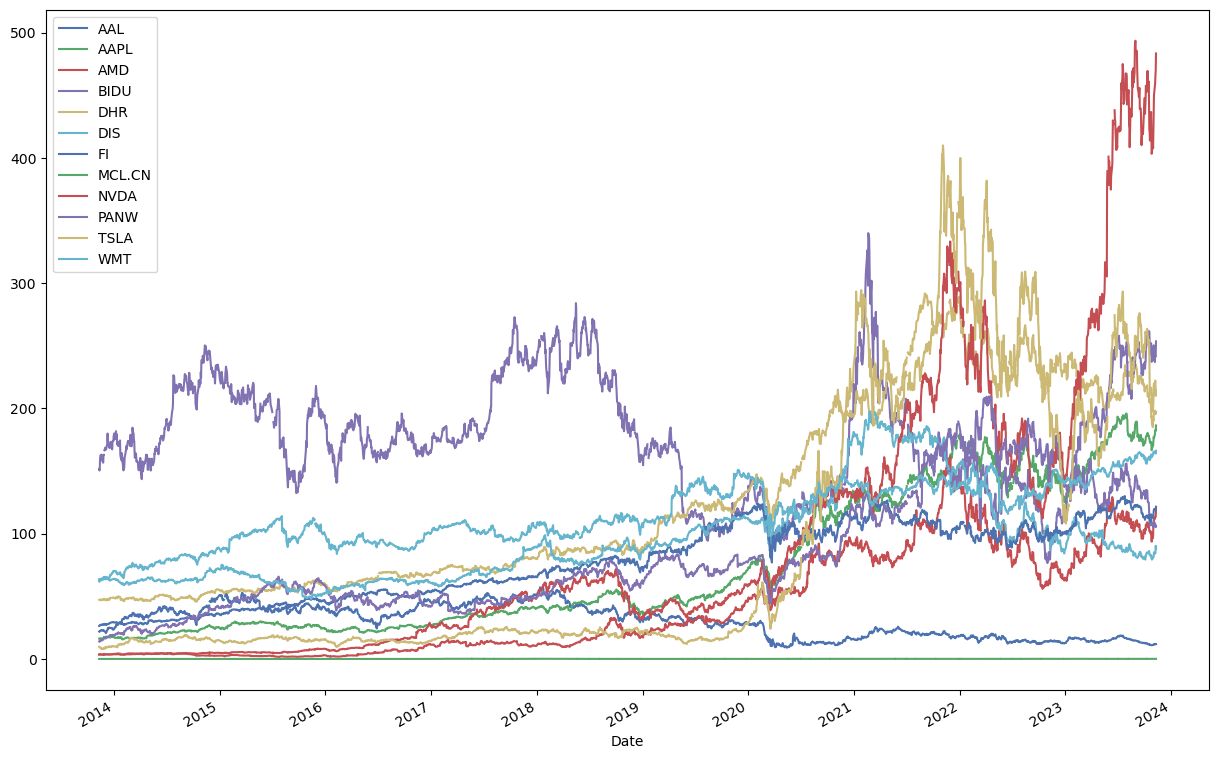

In [7]:
#Quick chart of prices over time for basket of stocks
prices[prices.index >= "2013-01-01"].plot(figsize=(15,10));

In [8]:
#created a covariance matrix through pyportfolioOpt to compare all stocks to eachother
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
AAL,0.25,0.04,0.06,0.06,0.03,0.06,0.04,-0.01,0.07,0.05,0.07,0.01
AAPL,0.04,0.08,0.07,0.04,0.03,0.03,0.03,0.00,0.07,0.04,0.07,0.02
AMD,0.06,0.07,0.33,0.07,0.05,0.04,0.04,0.01,0.15,0.07,0.11,0.02
BIDU,0.06,0.04,0.07,0.20,0.03,0.04,0.03,0.01,0.07,0.05,0.08,0.01
DHR,0.03,0.03,0.05,0.03,0.05,0.02,0.03,0.00,0.05,0.03,0.04,0.01
DIS,0.06,0.03,0.04,0.04,0.02,0.07,0.04,0.01,0.05,0.04,0.04,0.01
FI,0.04,0.03,0.04,0.03,0.03,0.04,0.06,-0.00,0.05,0.03,0.04,0.02
MCL.CN,-0.01,0.00,0.01,0.01,0.00,0.01,-0.00,3.54,0.00,-0.02,0.01,0.00
NVDA,0.07,0.07,0.15,0.07,0.05,0.05,0.05,0.00,0.21,0.07,0.11,0.02
PANW,0.05,0.04,0.07,0.05,0.03,0.04,0.03,-0.02,0.07,0.15,0.08,0.01


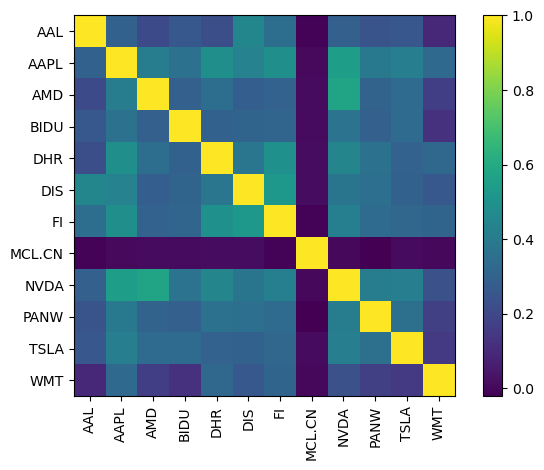

In [9]:
#plotted the correlations.  MCL.CN is the interesting product here with low correlation to essentially all other products here.
plotting.plot_covariance(sample_cov, plot_correlation=True);

In [10]:
#Used pyportfolioOpt to find our expected returns per stock using Capital Asset Pricing Model.
mu = expected_returns.capm_return(prices)
mu

AAL      0.34
AAPL     0.25
AMD      0.47
BIDU     0.33
DHR      0.18
DIS      0.22
FI       0.20
MCL.CN   1.58
NVDA     0.42
PANW     0.28
TSLA     0.45
WMT      0.11
Name: mkt, dtype: float64

In [ ]:
# Use hvplot.bar to create bar plot with categorical data
bar_chart=pd.DataFrame(mu)
bar_chart.hvplot.bar(
    x="index", 
    y="mkt", 
    color="green",
    xlabel="Ticker", 
    ylabel="Daily Return", 
    title="Daily Return",
    rot=90
)

In [ ]:

#PyportfolioOpt finding weights for our optimized portfolio on the efficient frontier
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #for maximizing the Sharpe ratio #Optimization
cleaned_weights = ef.clean_weights() #to clean the raw weights
# Get the Keys and store them in a list
labels = list(cleaned_weights.keys())
# Get the Values and store them in a list
values = list(cleaned_weights.values())
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.0f%%')
print('Portfolio Allocation')
plt.show(fig)

In [ ]:
#Displaying cleaned weights dictionary output
cleaned_weights

In [ ]:
#Taking the cleaned weights and inserting them into a df.  
#Named columns and set the index as the Stock column to easily work with additional downstream data.
clean_weights_df = pd.DataFrame(list(cleaned_weights.items()), columns=['Stock', 'Weight'])
clean_weights_df.set_index("Stock", inplace=True)
clean_weights_df

In [ ]:
#Finding the discrete allocation using pyportfolioOpt with prices on a given date, our weights, and portfolio size
latest_prices = prices.loc[portfolio_creation_date]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio(verbose=False)
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

In [ ]:
ef.portfolio_performance(verbose=True);

In [ ]:
idx = pd.date_range( start='2013-01-01',end='2023-11-09', freq='M')

stock_data_pctchange = prices.pct_change().cumsum()

stock_data_pctchange.dropna(how="all")

In [ ]:
stock_data_pctchange.hvplot.line(
    xlabel="Year", 
    ylabel="Daily Return",
    title="Value"
)

In [ ]:
#Taking the allocation dictionary above and inserting it into  df.
alloc_df = pd.DataFrame(list(alloc.items()), columns=['Stock', 'Value'])
alloc_df.set_index("Stock", inplace=True)
alloc_df

In [ ]:
#Checking current values per given stock
current_values = prices.loc[portfolio_rebalance_date] * alloc_df["Value"]
current_values

In [ ]:
#Taking the sum
current_values_sum = current_values.sum(numeric_only=True)
current_values_sum

In [ ]:
#Adding cash leftover
total_value = current_values_sum + leftover
total_value

In [ ]:
#Getting the daily returns per stock
combined_returns_ef = prices.pct_change()
combined_returns_ef

In [ ]:
#Finding the returns of the optimized portfolio
portfolio_returns_ef = combined_returns_ef.dot(clean_weights_df["Weight"])
portfolio_returns_ef

In [ ]:
#Finding the cumulative returns of the optimized portfolio
cumulative_returns_ef = (1 + portfolio_returns_ef).cumprod()
cumulative_returns_ef

In [ ]:
#Simulating growth of our 100k initial investment
investment_ammount = 100000
cumulative_profit_ef = investment_ammount * cumulative_returns_ef
cumulative_profit_ef.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of Optimized Portfolio",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

In [ ]:
#Dictionary of equal weights
equal_weights = {'AAL': 0.08333,
             'BIDU': 0.08333,
             'DHR': 0.08333,
             'DIS': 0.08333,
             'FI': 0.08333,
             'AAPL': 0.08333,
             'MCL.CN': 0.08333,
             'NVDA': 0.08333,
             'PANW': 0.08333,
             'AMD': 0.08333,
             'TSLA': 0.08333,
             'WMT': 0.08333}

print(equal_weights)

In [ ]:
#Inserting equal weights into a df
equal_weights_df = pd.DataFrame(list(equal_weights.items()), columns=['Stock', 'Weight'])
equal_weights_df.set_index("Stock", inplace=True)
equal_weights_df

In [ ]:
#Using PyportfolioOpt again to find allocations for this equal weight portfolio
latest_prices = prices.loc[portfolio_creation_date]  # prices as of the day you are allocating
da_ew = DiscreteAllocation(equal_weights, latest_prices, total_portfolio_value=100000)
alloc_ew, leftover_ew = da_ew.lp_portfolio(verbose=False)
print(f"Discrete allocation performed with ${leftover_ew:.2f} leftover")
alloc_ew

In [ ]:
#Inserting allocations into a df
alloc_ew_df = pd.DataFrame(list(alloc_ew.items()), columns=['Stock', 'Value'])
alloc_ew_df.set_index("Stock", inplace=True)
alloc_ew_df

In [ ]:
#Finding the current values per stock
current_values_ew = prices.loc[portfolio_rebalance_date] * alloc_ew_df["Value"]
current_values_ew

In [ ]:
#Finding the current value of the portfolio
current_values_ew_sum = current_values_ew.sum(numeric_only=True)
current_values_ew_sum

In [ ]:
#adding the leftover cash back to get the total value
total_value_ew = current_values_ew_sum + leftover_ew
total_value_ew

In [ ]:
#Getting returns for our equal weight portfolio
combined_returns_ew = prices.pct_change()
combined_returns_ew

In [ ]:
#test_weights = [0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833]
portfolio_returns_ew = combined_returns_ew.dot(equal_weights_df)

In [ ]:
#Getting cumulative returns for our equal weight portfolio
cumulative_returns_ew = (1 + portfolio_returns_ew).cumprod()
cumulative_returns_ew

In [ ]:
#investment_ammount = 100000
cumulative_profit_ew = investment_ammount * cumulative_returns_ew
cumulative_profit_ew.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of Equal Weight Portfolio",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

In [ ]:
#Getting 10y data for SPY, our baseline
spy = ["SPY"] 
spy_data = yf.download(spy, period="10y")

In [ ]:
#Closing prices for SPY
spy_prices = pd.DataFrame(spy_data["Adj Close"].dropna(how="all"))
spy_prices.tail()

In [ ]:
# Calculate Daily Returns
daily_returns_spy = spy_prices.pct_change()
daily_returns_spy.columns = ["SPY"]
daily_returns_spy.head()

In [ ]:
#SPY cumulative returns
cumulative_returns_spy = (1 + daily_returns_spy).cumprod()
cumulative_returns_spy.head()

In [ ]:
#Getting std dev for spy
stddev_spy = daily_returns_spy.std()
stddev_spy

In [ ]:
#spy std dev annualized
stddev_annualized_spy = stddev_spy * np.sqrt(252)
stddev_annualized_spy

In [ ]:
#Calculating SPY Sharpe Ratio
sharpe_ratio_spy = (daily_returns_spy.mean() * 252) / (stddev_annualized_spy)
sharpe_ratio_spy

In [ ]:
#SPY expected returns
mu_spy = expected_returns.capm_return(spy_prices)
mu_spy

In [ ]:
cumulative_profit_spy = investment_ammount * cumulative_returns_spy
cumulative_profit_spy.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of the SP500 using SPY",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

In [ ]:
#Combining the 3 portfolios to 1 df to better display results
combined_df = pd.concat([cumulative_profit_ef,cumulative_profit_ew,cumulative_profit_spy], axis='columns', join='inner')
combined_df.columns = ["Optimized", "Equal Weight","SPY"]
combined_df

In [ ]:
combined_df.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profits Compared",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')